In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.table import Table
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from astropy import wcs
from astropy.stats import sigma_clip
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
#import pandas as pd
from ppxf import robust_sigma
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, MUSE_1D_residual, data_cube_y_x
import sep
from photutils import CircularAperture

%config InlineBackend.figure_format = 'retina'

In [2]:
# Open Fits file and assign to raw_data
#hdulist = fits.open("FCC167_data/FCC167_OIII_line_center.fits")
#raw_data = hdulist[0].data
#hdr = hdulist[0].header
#hdulist = fits.open("FCC167_data/FCC167_gandalf-residuals_SPAXEL.fits")
hdulist = fits.open("FCC167_data/FCC167_residuals.fits")
hdr = hdulist[0].header
raw_data = hdulist[0].data
y_data = hdr["NAXIS2"]
x_data = hdr["NAXIS1"]
wavelength = np.exp(hdulist[1].data)
#hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3']

#np.save("exported_data/FCC167/wavelength", wavelength)
y_data = hdr["NAXIS2"]
x_data = hdr["NAXIS1"]

coordinates = [(n,m) for n in range(x_data) for m in range(y_data)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

raw_data_list_for_swap = np.array(raw_data).reshape(len(wavelength),x_data*y_data)
raw_data_list = np.swapaxes(raw_data_list_for_swap, 1, 0)
#wavelength = full_wavelength[180:350]
#raw_data_list = raw_data_list[:,180:350][:]
non_zero_index = np.squeeze(np.where(raw_data_list[:,0] != 0.))

list_of_std = np.abs(np.std(raw_data_list,1))
input_errors = [np.repeat(item, len(wavelength)) for item in list_of_std]

# 1D fit function

In [4]:
list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(full_wavelength)) for i in np.arange(0,len(list_of_std))]
# setup numpy arrays for storage
best_fit_A = np.zeros((len(raw_data_list),2))
list_of_rN = np.zeros(len(raw_data_list))
data_residuals = np.zeros((len(raw_data_list),len(full_wavelength)))
obj_residuals = np.zeros((len(raw_data_list),len(full_wavelength)))
# setup LMfit paramterts
params = Parameters()
params.add("Amp",value=70., min=0.001, max=500.)
params.add("wave", value=5025, min=4980, max=5080)
params.add("FWHM", value=2.81, vary=False) # Line Spread Function
params.add("Gauss_bkg", value=0.001)
params.add("Gauss_grad", value=0.001)

In [ ]:
for i in non_zero_index:
    useful_list = []
    fit_results = minimize(MUSE_1D_residual, params, args=(wavelength, raw_data_list[i], input_errors[i], i, useful_list), nan_policy="propagate")
    best_fit_A[i] = [fit_results.params["Amp"], fit_results.params["Amp"].stderr]
    obj_residuals[i] = fit_results.residual
    data_residuals[i] = useful_list[0][0]
    list_of_rN[i] = useful_list[0][1]

In [8]:
gauss_A = [A[0] for A in best_fit_A]
A_err = [A[1] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
A_rN_shape = A_rN.reshape(y_data,x_data)

Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

In [8]:
np.save("exported_data/FCC167/A_rN_cen", A_rN)
np.save("exported_data/FCC167/gauss_A_cen", gauss_A)
np.save("exported_data/FCC167/gauss_A_err_cen", A_err)
np.save("exported_data/FCC167/gauss_F_cen", Gauss_F)
np.save("exported_data/FCC167/list_of_resids_min", list_of_residuals)
np.save("exported_data/FCC167/list_of_resids_min_obj", list_of_residuals_from_fitter)
np.save("exported_data/FCC167/rN", list_of_rN)

In [8]:
A_rN = np.load("exported_data/FCC167/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC167/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC167/gauss_F_cen.npy")
#rN = np.load("exported_data/FCC167/rN.npy")

#rN_shape = np.abs(rN).reshape(y_data, x_data)
gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

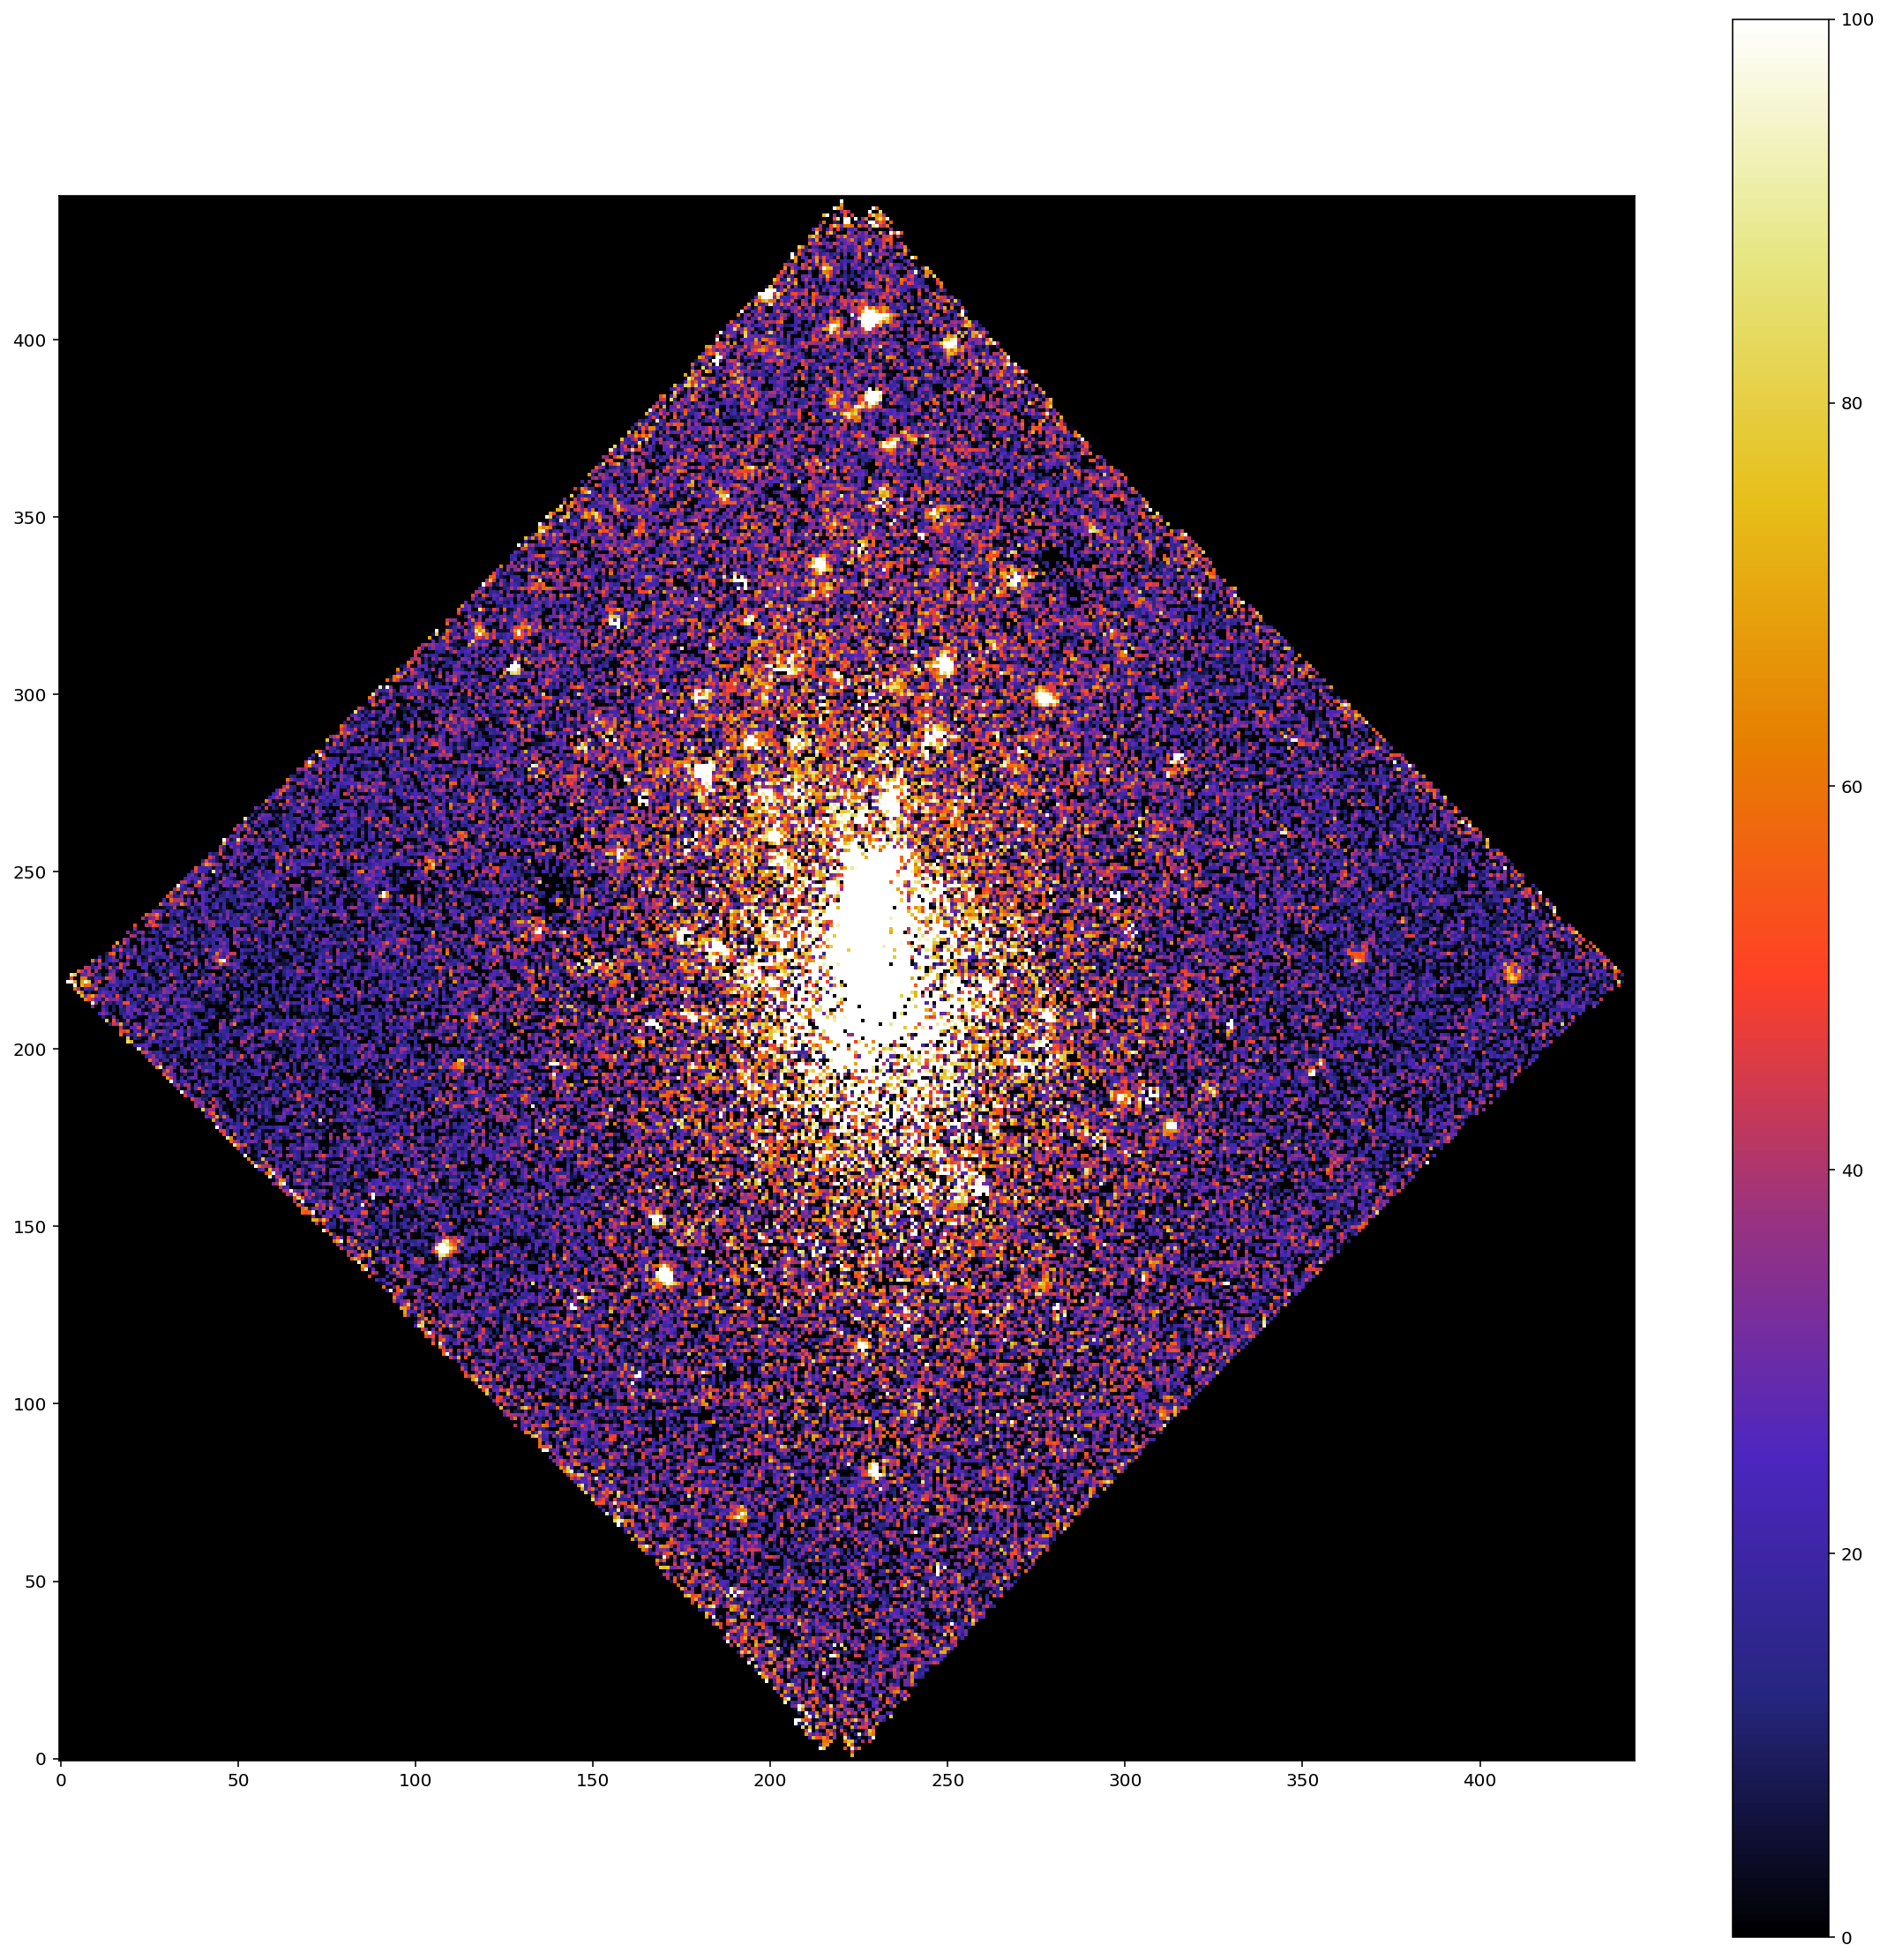

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(Gauss_F_shape, origin="lower", cmap="CMRmap", vmin=0, vmax=100)
plt.colorbar()

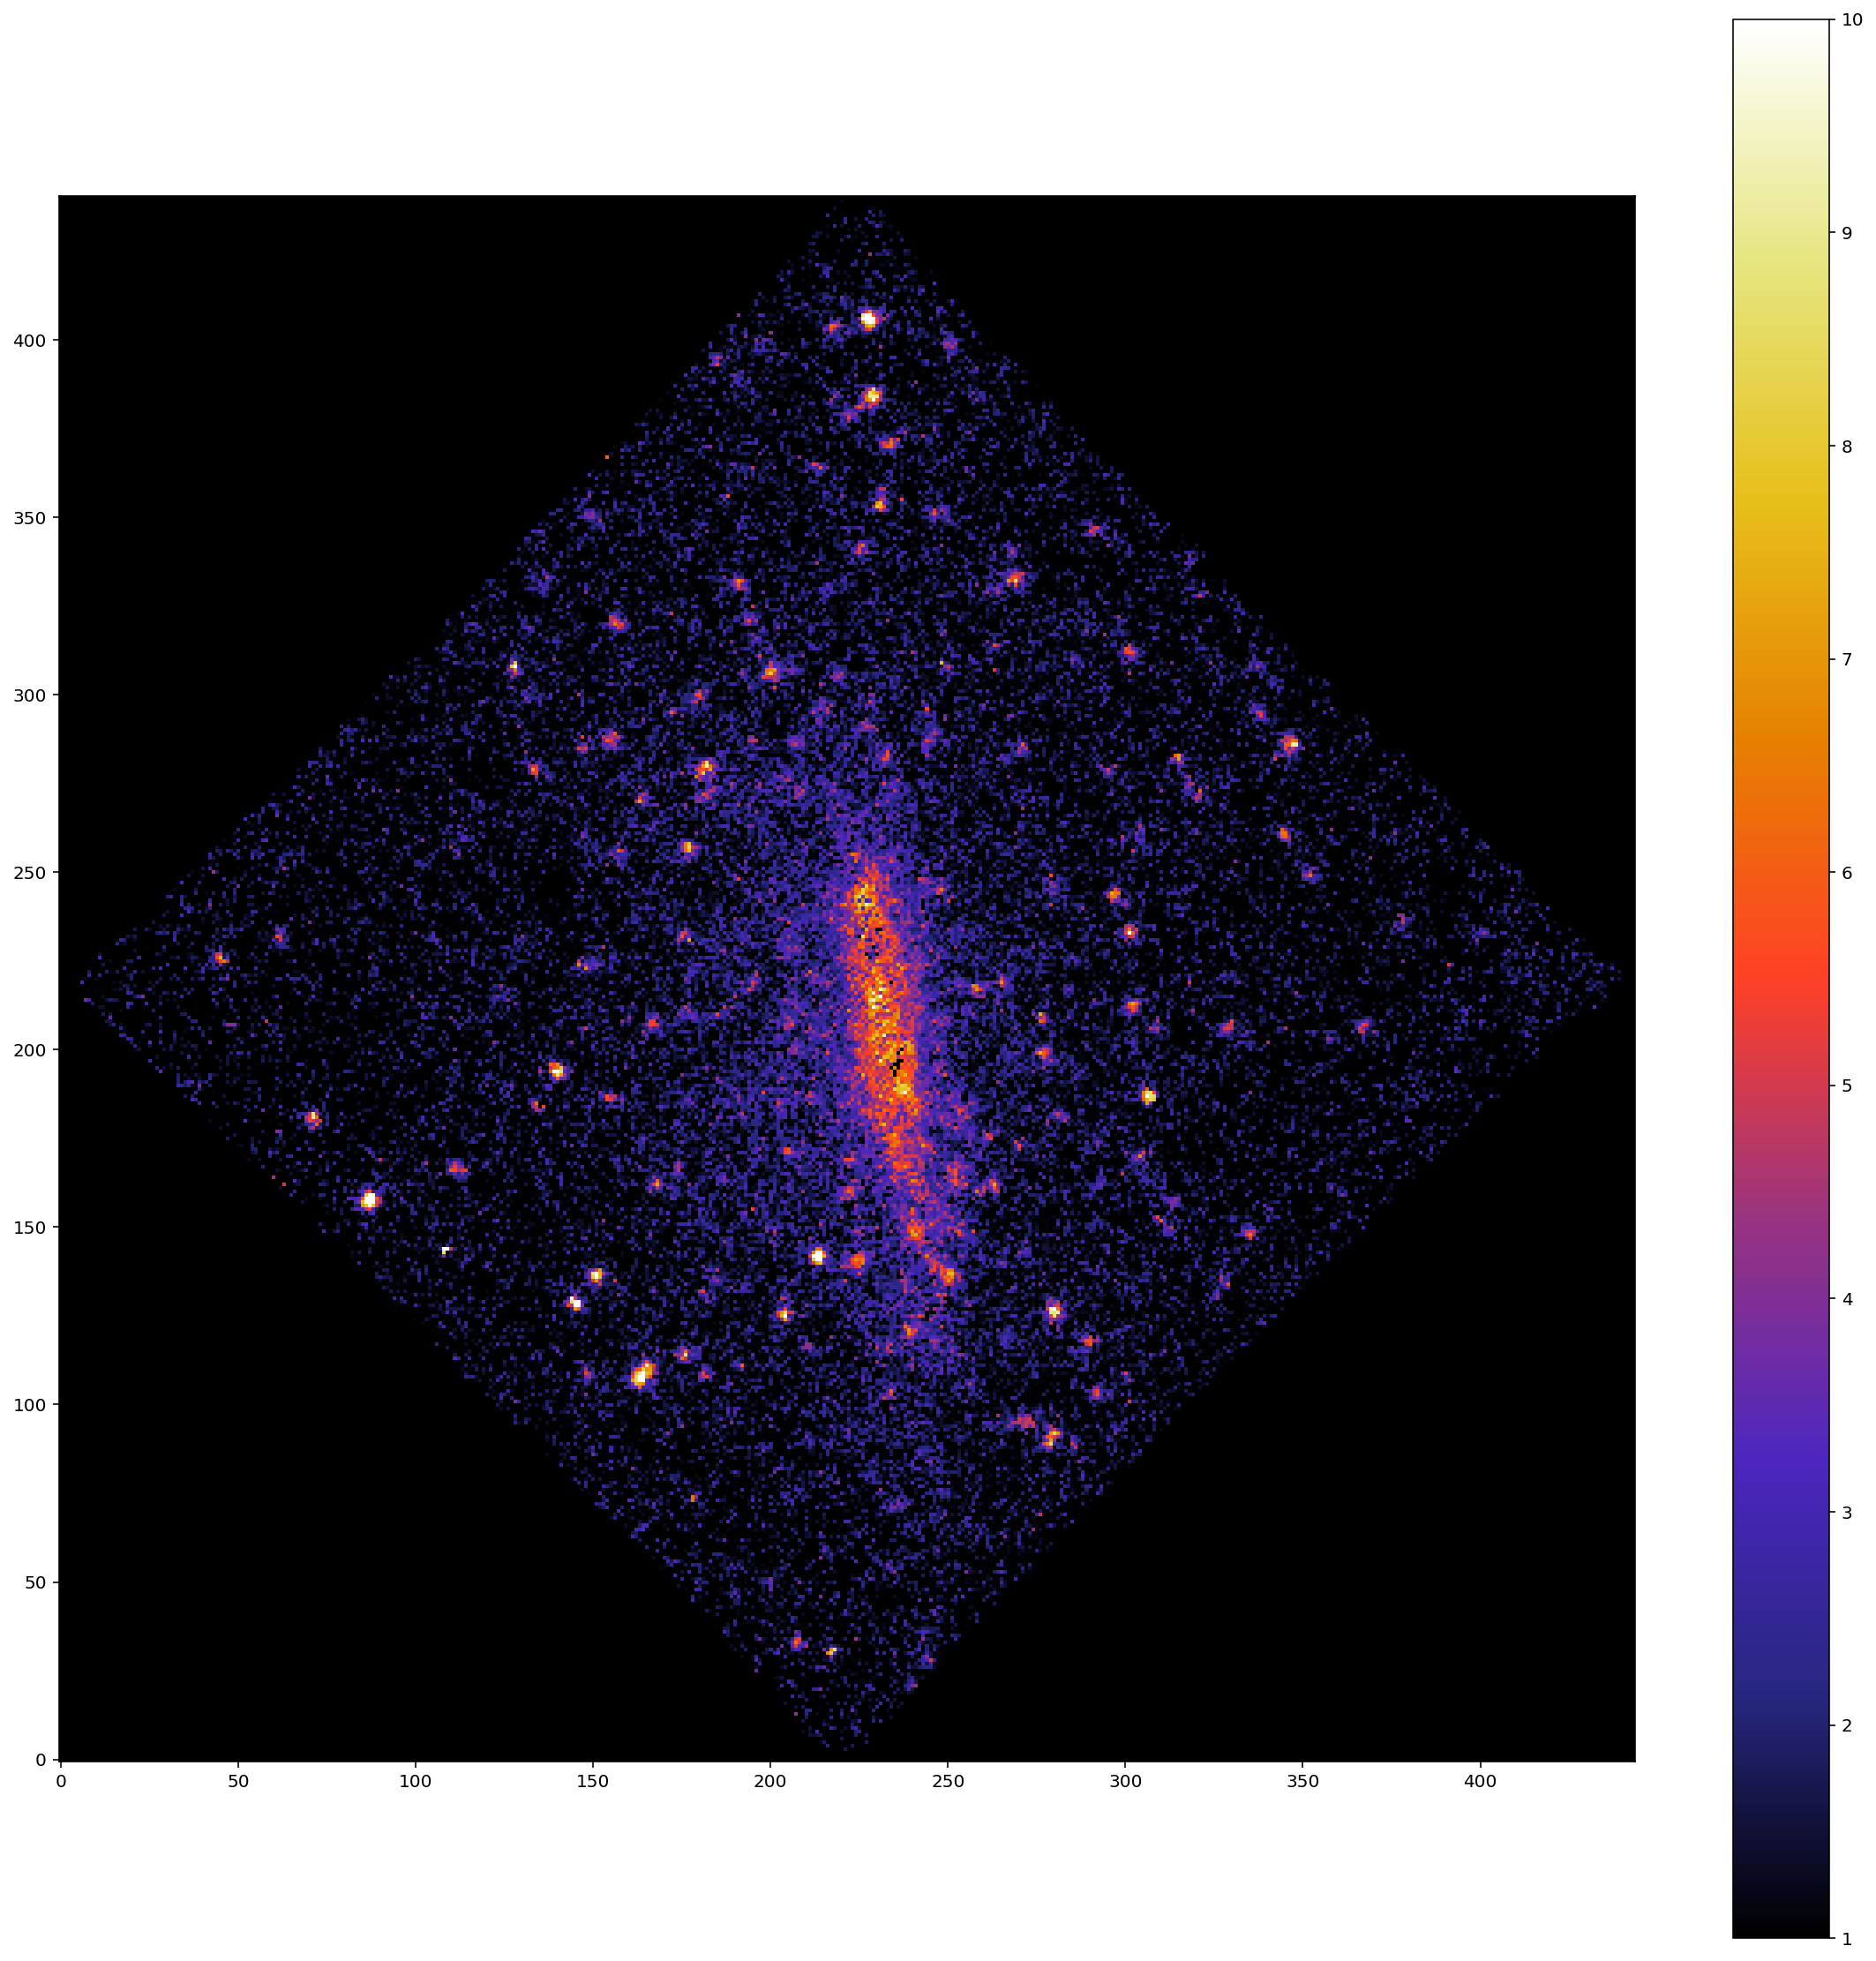

In [4]:
A_o_N_hdu = fits.open("FCC167_data/FCC167_AoN.fits")
A_o_N_data = A_o_N_hdu[0].data.byteswap().newbyteorder()
plt.figure(figsize=(20,20))
plt.imshow(A_o_N_data, origin="lower", cmap="CMRmap", vmin=1, vmax=10)
plt.colorbar()
#plt.savefig("Plots/FCC167/for_boris.png")

111


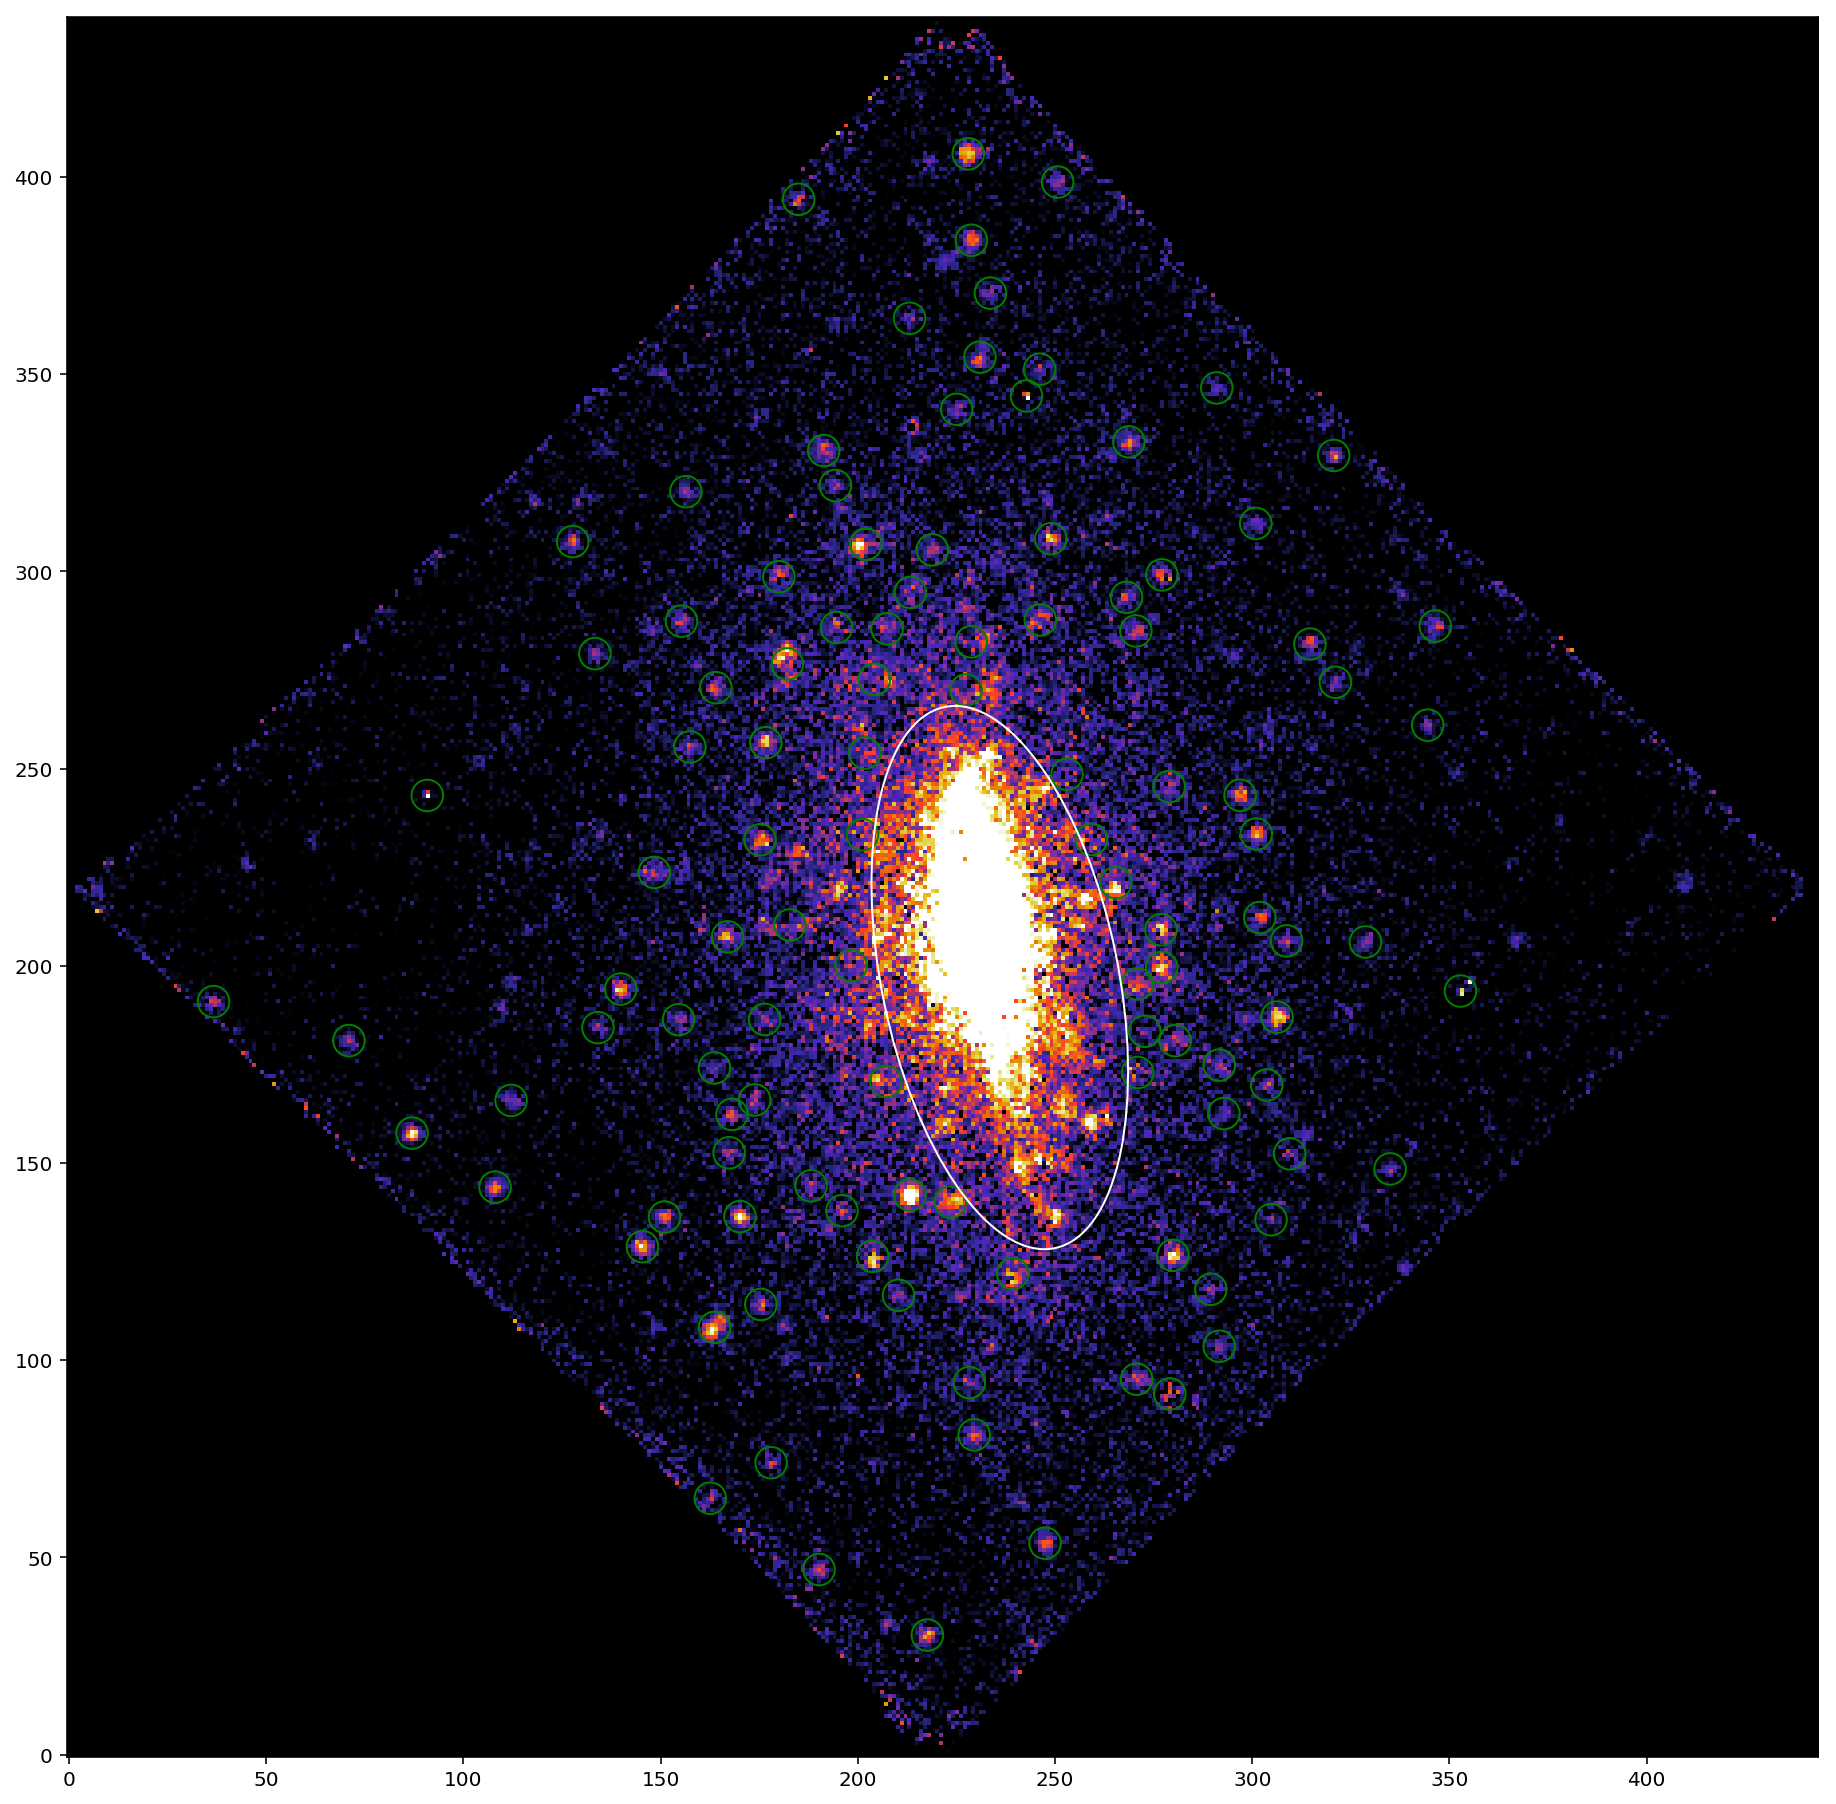

In [80]:
import sep
from photutils import CircularAperture

A_rN_shape[A_rN_shape == A_rN_shape[0,0]] = 0.0

Y, X = np.mgrid[:y_data, :x_data]
xe = 236
ye = 197
length= 140
width = 60

alpha = 0.2
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
PNe_17_mask = (X-213)**2 + (Y-142)**2 <=4**2
#galaxy_elip_mask = np.load("exported_data/FCC167/mask.npy")
#objects = sep.extract(gauss_A.reshape(441, 444), 7., err=list_of_std.reshape(y_data, x_data), clean=False, mask=elip_mask)
objects = sep.extract(gauss_A_shape, 20, clean=True, mask=elip_mask_gal)#+PNe_17_mask)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(gauss_A_shape, origin="lower", cmap="CMRmap", vmin=10, vmax=80.)
apertures.plot(color="green")

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
PNe_17 = Circle((213,142), fill=False, color="white")
#elip_extra = Ellipse((210,230), 20, 50, angle=alpha*(180/np.pi), fill=False, color="white")

ax.add_artist(elip_gal)
#ax.add_artist(PNe_17)

#ax.add_artist(circ)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]

print(len(x_sep))
np.save("exported_data/FCC167/sep_x_y_list", sep_x_y_list)

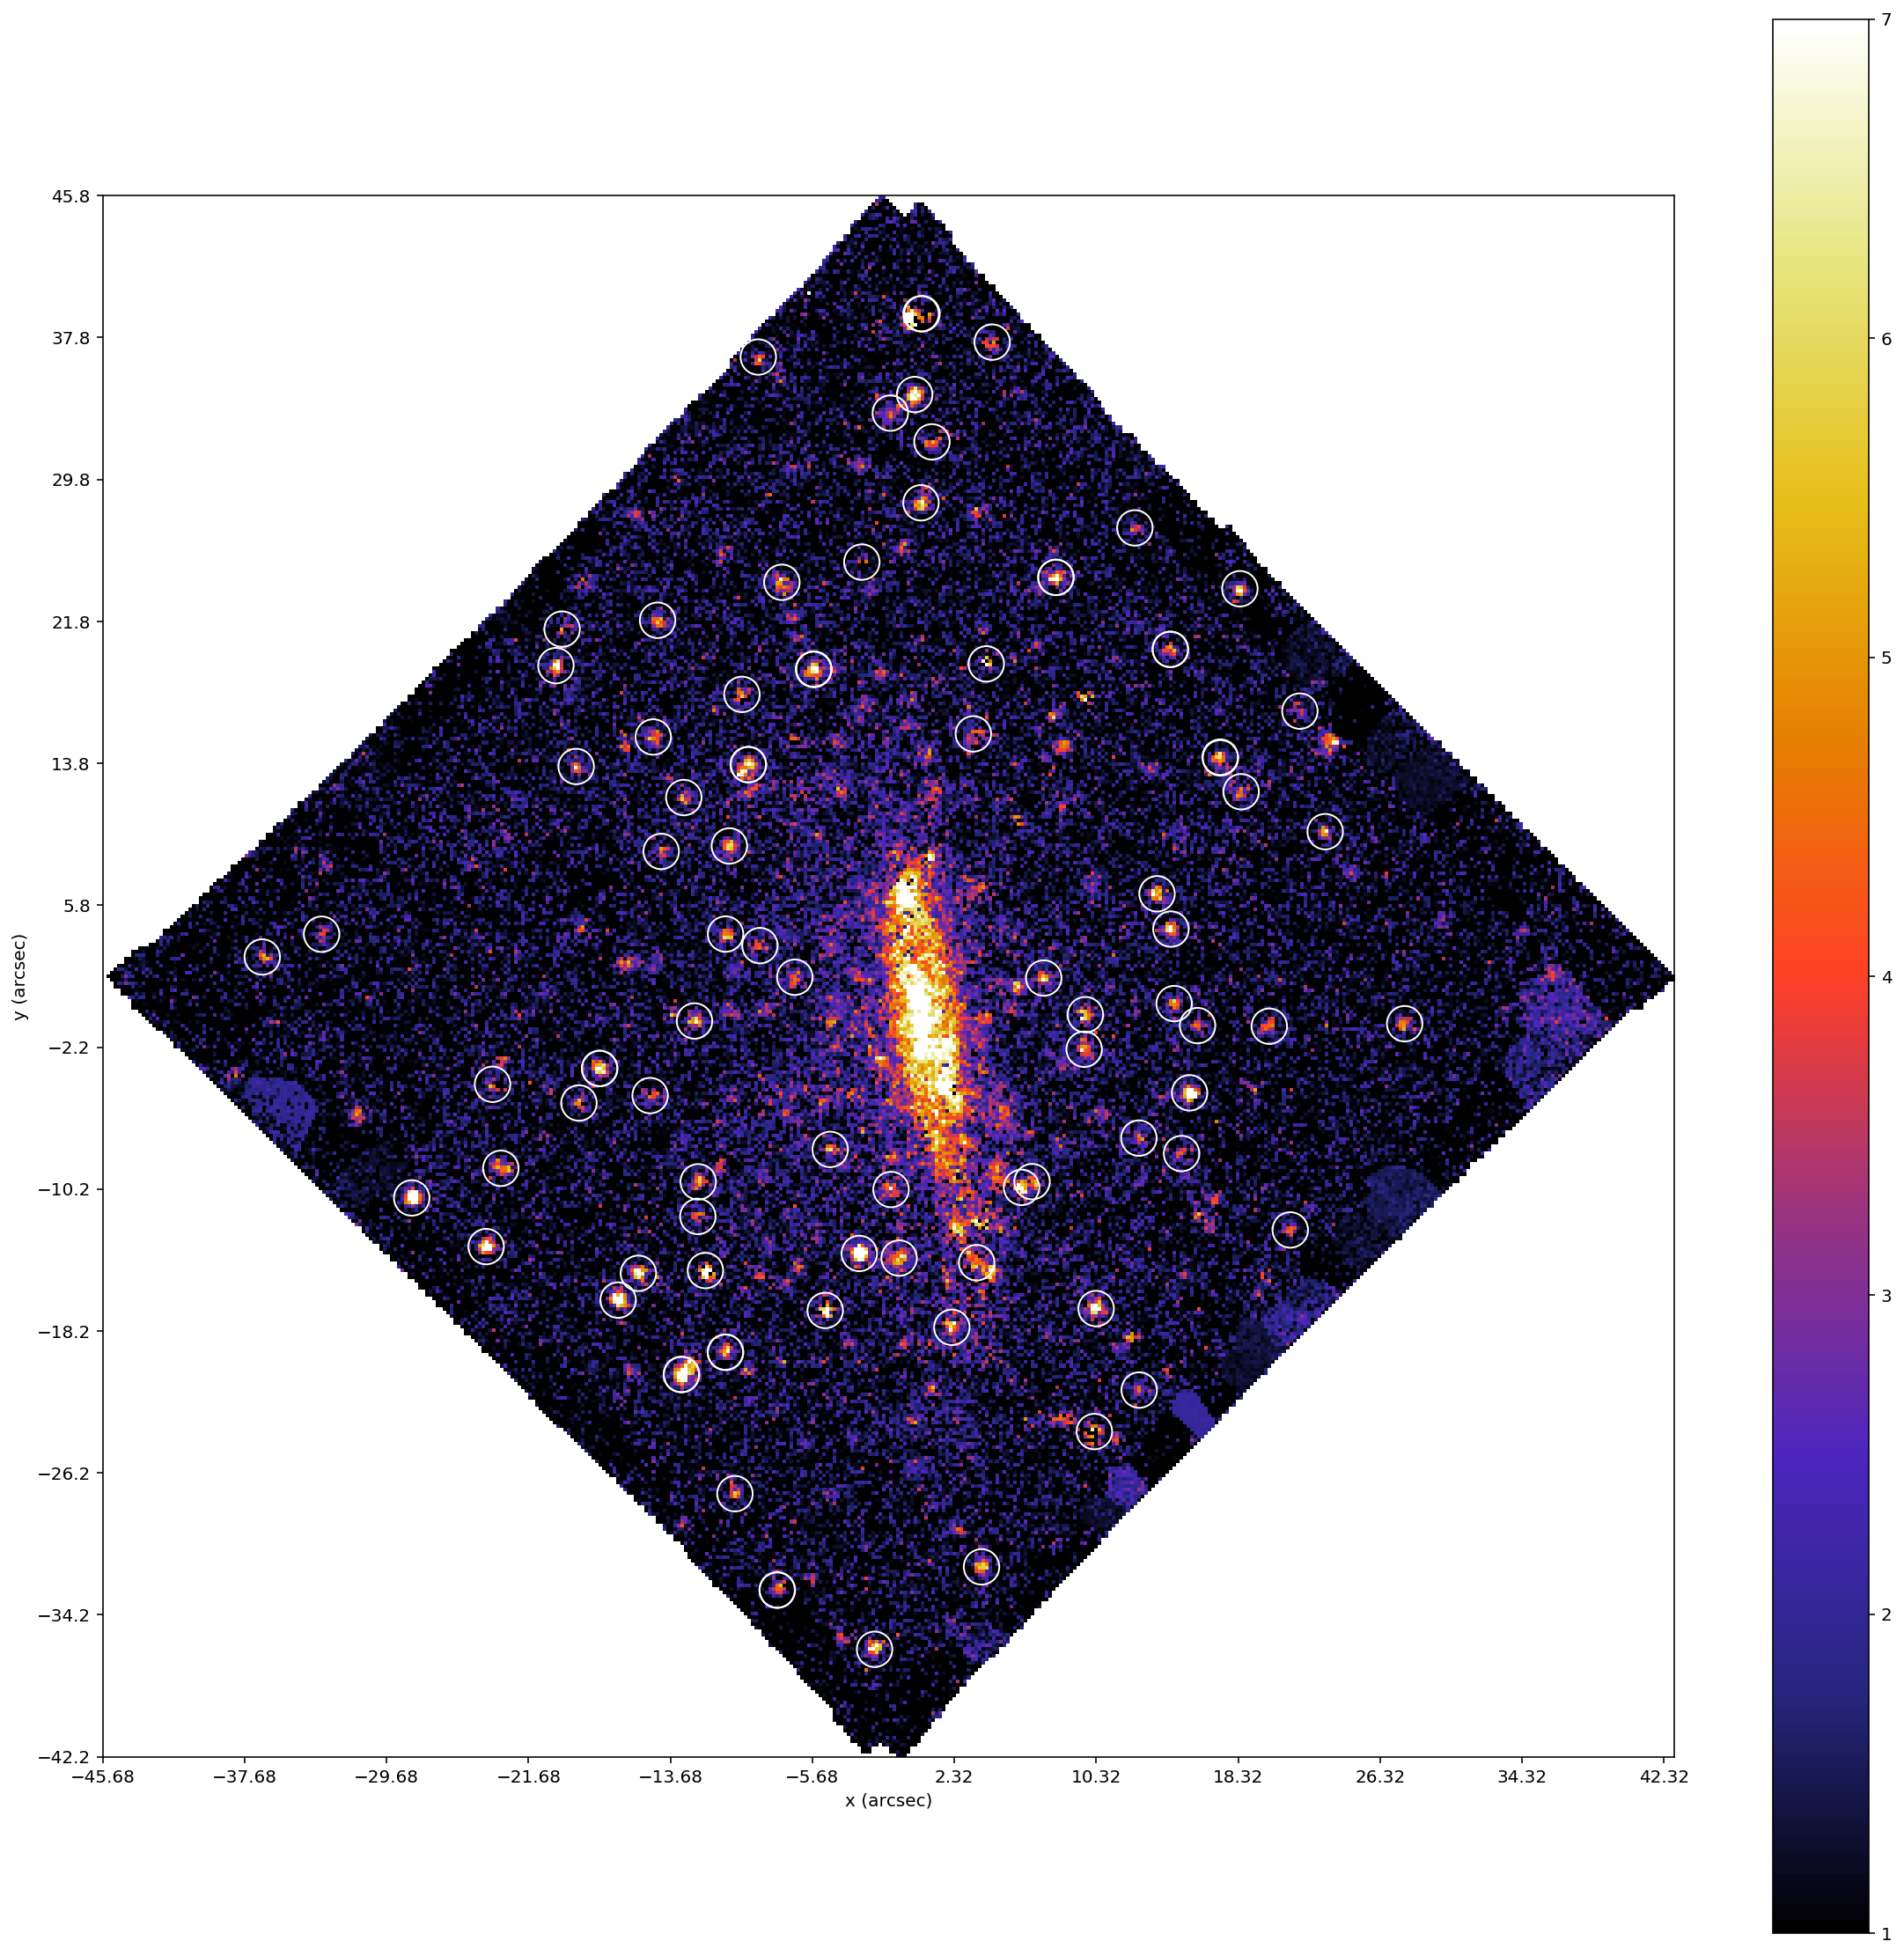

In [9]:
coords = ascii.read("FCC167_data/FCC167_xy_PNe_Marc_forThomas.txt", names=["x_PNe", "y_PNe"])
x_PNe = coords["x_PNe"]
y_PNe = coords["y_PNe"]
x_y_list = [x_PNe, y_PNe]

coords_arc = ascii.read("FCC167_data/FCC167_xy_forThomas.txt", names=["x","y"])
x_arc = coords_arc["x"][:444]
y_arc = coords_arc["y"][::444]

plt.figure(3,figsize=(20,20))
plt.imshow(A_rN_shape, extent = (x_arc[0], x_arc[-1], y_arc[0],y_arc[-1]), origin="lower", cmap="CMRmap", vmin=1, vmax=7)
plt.xticks(x_arc[::40])
plt.yticks(y_arc[::40])
cb = plt.colorbar()
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

for x, y in zip(x_PNe,y_PNe):
    ax = plt.gca()
    circ = plt.Circle((x,y),1, color="white", fill=False)
    ax.add_artist(circ)
    plt.draw()
    
plt.savefig("Plots/FCC167_circled points.png")
#for i, item in enumerate(x_y_list):
#    ax = plt.gca()
#    circ = plt.Circle((item[0],item[1]),6, color="white", fill=False)
#    ax.add_artist(circ)
#    ax.annotate(i+1, (item[0]-8, item[1]-16), color="white", size=25)
#   plt.draw()